# Import Library

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px
import copy
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud

# Load Data

In [164]:
df = pd.read_csv("your_custom_path/your_dataset.csv")

In [165]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [166]:
def null_count():
    return pd.DataFrame({
        'features': df.columns,
        'dtypes' : df.dtypes.values,
        'Nan count' : df.isnull().sum().values,
        'Nan percentage' : df.isnull().sum().values/df.shape[0]
    }).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()

,features,dtypes,Nan count,Nan percentage
0,Unnamed: 0.1,int64,0,0.000000
1,Unnamed: 0,int64,0,0.000000
2,Text,object,0,0.000000
3,Sentiment,object,0,0.000000
4,Timestamp,object,0,0.000000
5,User,object,0,0.000000
6,Platform,object,0,0.000000
7,Hashtags,object,0,0.000000
8,Retweets,float64,0,0.000000
9,Likes,float64,0,0.000000


In [167]:
df.duplicated().sum()

0

In [168]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [169]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

Unnamed: 0.1: 732 distinct values
Unnamed: 0: 732 distinct values
Text: 707 distinct values
Sentiment: 279 distinct values
Timestamp: 683 distinct values
User: 685 distinct values
Platform: 4 distinct values
Hashtags: 697 distinct values
Retweets: 26 distinct values
Likes: 38 distinct values
Country: 115 distinct values
Year: 14 distinct values
Month: 12 distinct values
Day: 31 distinct values
Hour: 22 distinct values


# Feature Enginering

Drop Columns

In [170]:
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags','Day', 'Hour','Sentiment'])

Platform

In [171]:
df['Platform'].value_counts()

Platform
Instagram     258
Facebook      231
Twitter       128
Twitter       115
Name: count, dtype: int64

In [172]:
df['Platform'] = df['Platform'].str.strip()

Country

In [173]:
df['Country'].value_counts()

Country
USA               59
USA               55
UK                49
Canada            44
Australia         41
                  ..
Netherlands        1
USA                1
Germany            1
France             1
USA                1
Name: count, Length: 115, dtype: int64

In [174]:
df['Country'] = df['Country'].str.strip()

Timestamp

In [175]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Day_of_Week'] = df['Timestamp'].dt.day_name() 

Month

In [176]:
month_mapping = {
    1: 'Januari',
    2: 'Februari',
    3: 'Maret',
    4: 'April',
    5: 'Mei',
    6: 'Juni',
    7: 'Juli',
    8: 'Agustus',
    9: 'September',
    10: 'Oktober',
    11: 'November',
    12: 'Desember',
}

df['Month'] = df['Month'].map(month_mapping)
df['Month'] = df['Month'].astype('object')

Text

In [177]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def clean_with_lemmatizer(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = " ".join(text.split())
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(cleaned_tokens)

df["Clean_Text"] = df["Text"].apply(clean_with_lemmatizer)

In [178]:
df['text_length'] = df['Clean_Text'].apply(len)
df['word_count'] = df['Clean_Text'].apply(lambda x: len(x.split()))

Unique Column

In [179]:
specified_columns = ['Platform','Country', 'Year','Month','Day_of_Week']

for col in specified_columns:
    total_unique_values = df[col].nunique()
    print(f'Total unique values for {col}: {total_unique_values}')

    top_values = df[col].value_counts()

    colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN, Fore.WHITE, Fore.LIGHTBLACK_EX, Fore.LIGHTRED_EX, Fore.LIGHTGREEN_EX]

    for i, (value, count) in enumerate(top_values.items()):
        color = colors[i % len(colors)]
        print(f'{color}{value}: {count}{Fore.RESET}')

    print('\n' + '=' * 30 + '\n')  

Total unique values for Platform: 3
Instagram: 258
Twitter: 243
Facebook: 231


Total unique values for Country: 33
USA: 188
UK: 143
Canada: 135
Australia: 75
India: 70
Brazil: 17
France: 16
Japan: 15
Germany: 14
Italy: 11
Spain: 6
South Africa: 6
Greece: 5
Netherlands: 4
Switzerland: 3
Portugal: 2
Austria: 2
Belgium: 2
Denmark: 2
Czech Republic: 2
Sweden: 2
Colombia: 1
Scotland: 1
Kenya: 1
Jamaica: 1
Ireland: 1
China: 1
Norway: 1
Cambodia: 1
Maldives: 1
Peru: 1
Jordan: 1
Thailand: 1


Total unique values for Year: 14
2023: 289
2019: 73
2020: 69
2021: 63
2022: 63
2018: 56
2017: 43
2016: 38
2015: 19
2011: 4
2012: 4
2013: 4
2014: 4
2010: 3


Total unique values for Month: 12
Februari: 85
Januari: 82
Agustus: 78
September: 77
Juni: 71
Juli: 62
April: 51
November: 49
Oktober: 48
Mei: 46
Maret: 44
Desember: 39


Total unique values for Day_of_Week: 7
Sunday: 119
Saturday: 115
Tuesday: 110
Friday: 108
Monday: 97
Thursday: 95
Wednesday: 88




# EDA

In [180]:
df1 = df.copy()

Sentiment Analysis

In [181]:
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head())

                         Clean_Text  Vader_Score Sentiment
0       enjoying beautiful day park       0.8074  positive
1          traffic terrible morning      -0.4767  negative
2          finished amazing workout       0.5859  positive
3  excited upcoming weekend getaway       0.3400  positive
4  trying new recipe dinner tonight       0.0000   neutral


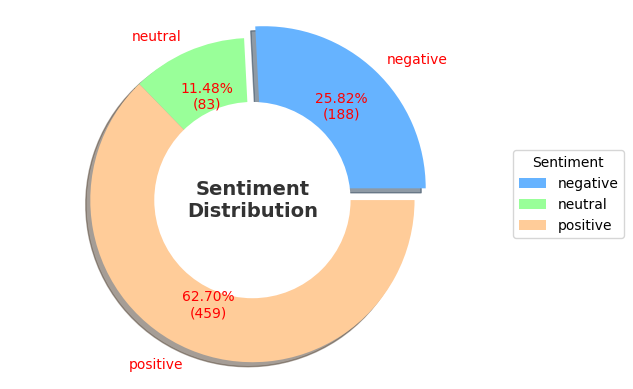

In [182]:
colors = ['#66b3ff', '#99ff99', '#ffcc99']

explode = (0.1, 0, 0)  

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()

Year

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future v

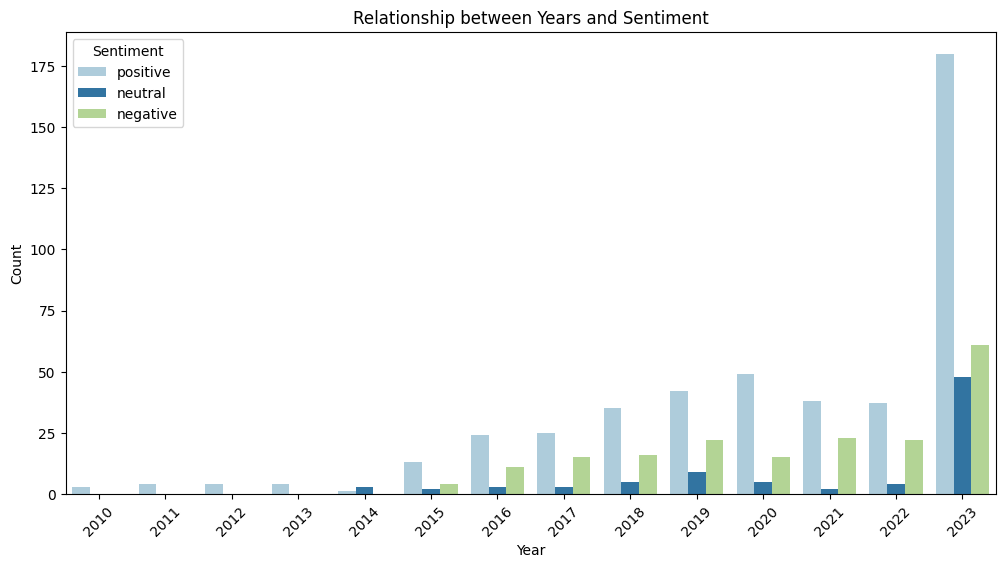

In [183]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Month

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future v

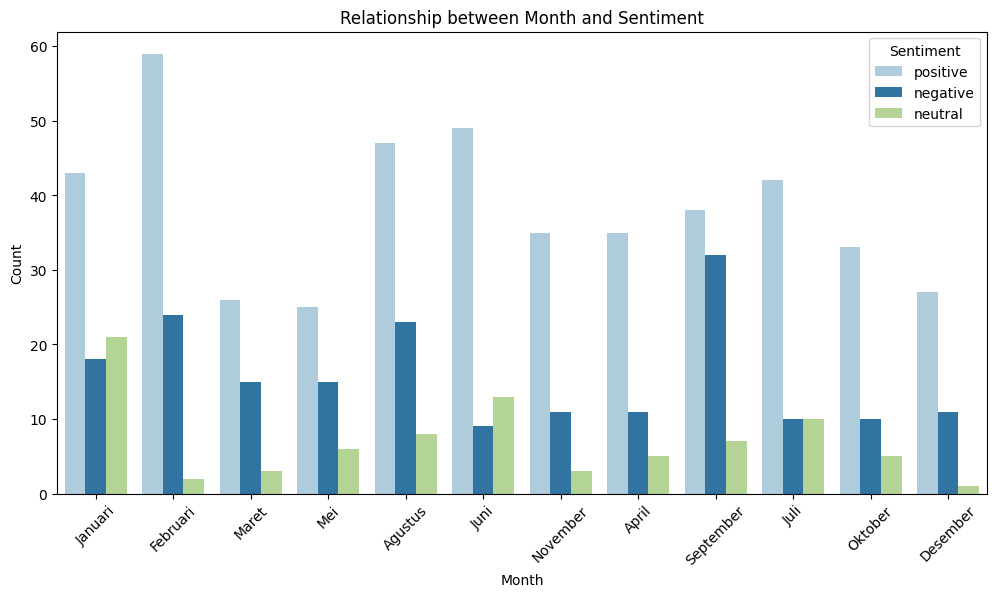

In [184]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Day of Week

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future v

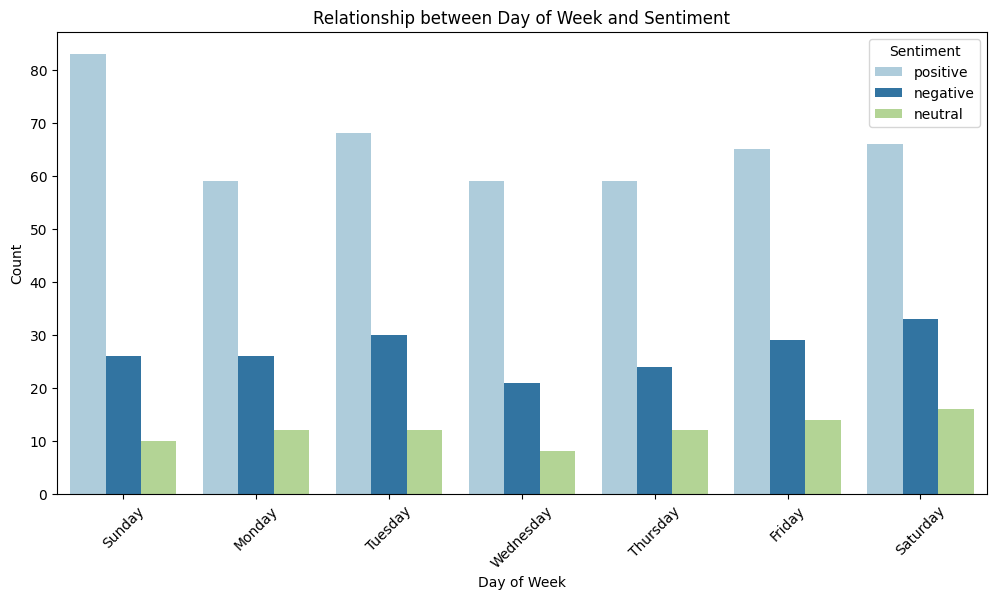

In [185]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Day_of_Week', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Platform

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future v

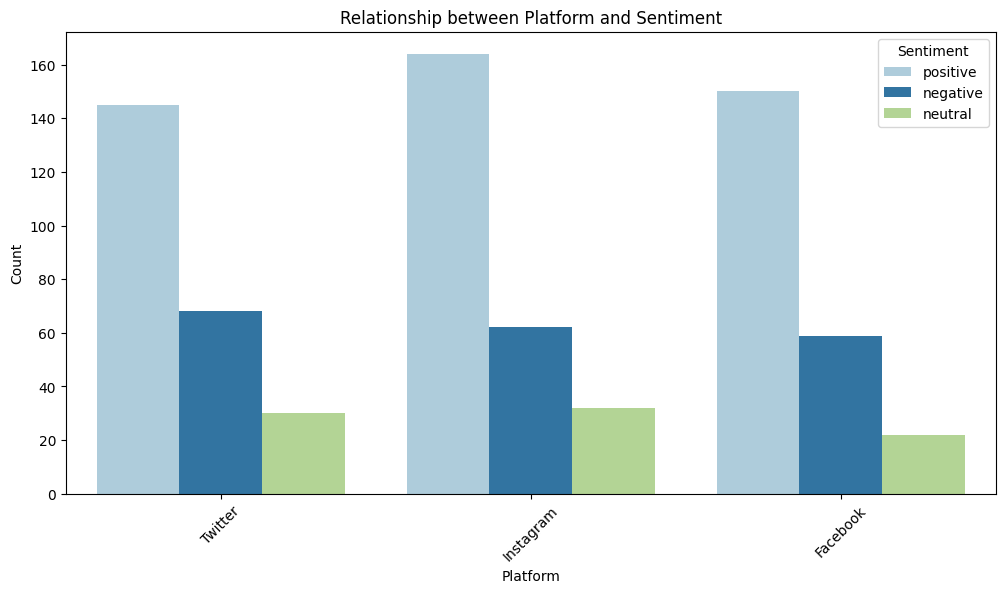

In [186]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Platform', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Country

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future v

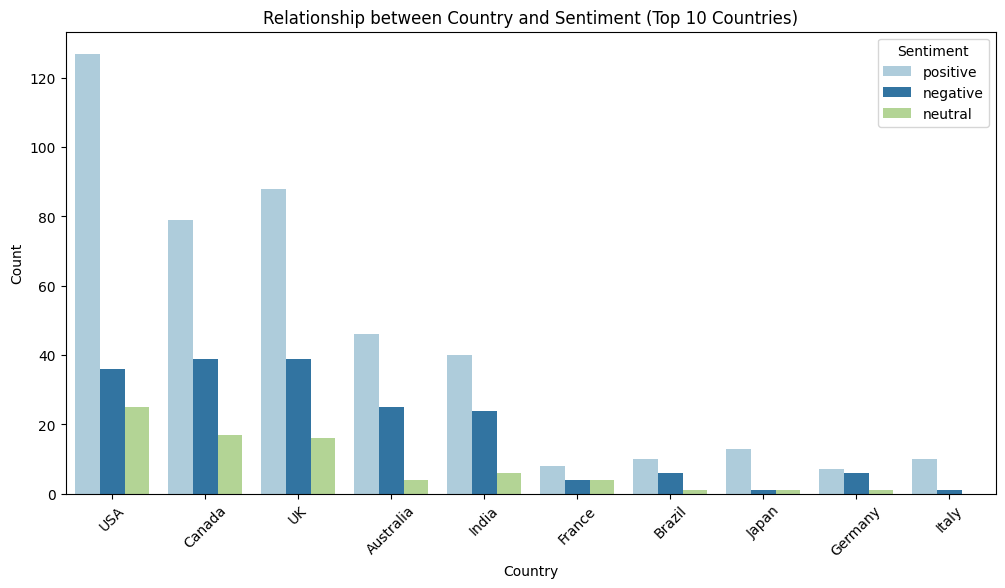

In [187]:
plt.figure(figsize=(12, 6))

top_10_countries = df1['Country'].value_counts().head(10).index

df_top_10_countries = df1[df1['Country'].isin(top_10_countries)]

sns.countplot(x='Country', hue='Sentiment', data=df_top_10_countries, palette='Paired')
plt.title('Relationship between Country and Sentiment (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Common Words

In [188]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,new,43
1,life,38
2,day,29
3,joy,28
4,dream,28
5,feeling,27
6,moment,27
7,like,27
8,friend,26
9,heart,26


In [189]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

fig = px.bar(top_words_df,
            x="count",
            y="Common_words",
            title='Common Words in Text Data',
            orientation='h',
            width=700,
            height=700,
            color='Common_words')

fig.show()

In [190]:
Positive_sent = df1[df1['Sentiment'] == 'positive']
Negative_sent = df1[df1['Sentiment'] == 'negative']
Neutral_sent = df1[df1['Sentiment'] == 'neutral']

Positive Common Words

In [191]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,new,29
1,joy,27
2,friend,24
3,laughter,24
4,life,23
5,beauty,20
6,challenge,19
7,moment,19
8,feeling,17
9,nature,16


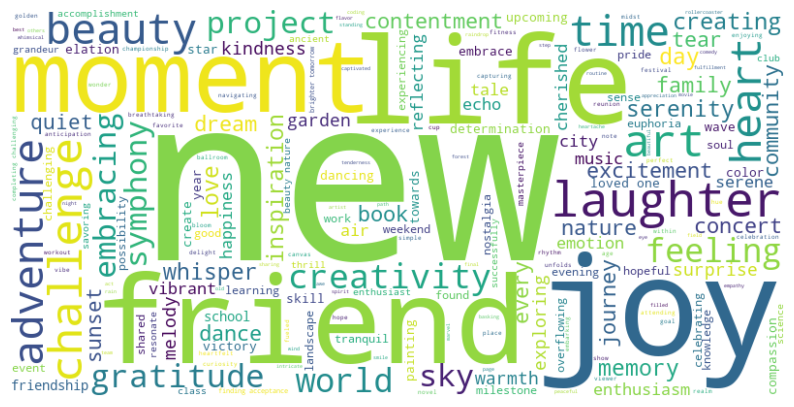

In [192]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Neutral Common Words

In [193]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Blues')

,Common_words,count
0,new,14
1,journey,7
2,night,7
3,exploring,6
4,trying,5
5,day,5
6,concert,5
7,curiosity,5
8,nostalgia,5
9,every,5


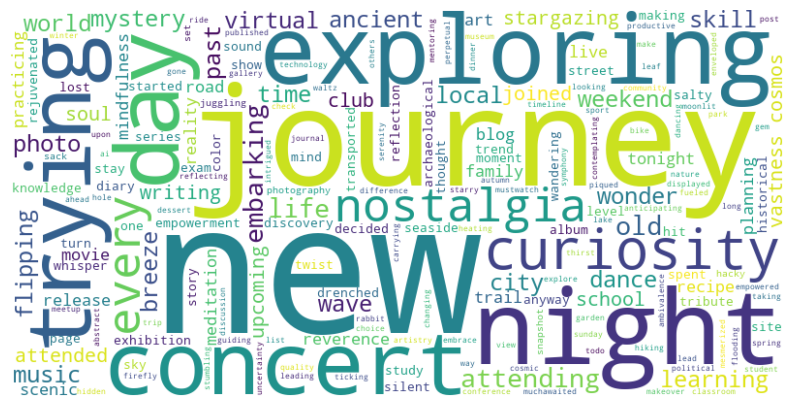

In [194]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Negative Common Words

In [195]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,shattered,14
1,day,13
2,despair,12
3,echo,12
4,lost,12
5,dream,12
6,like,12
7,life,11
8,heart,11
9,thought,11


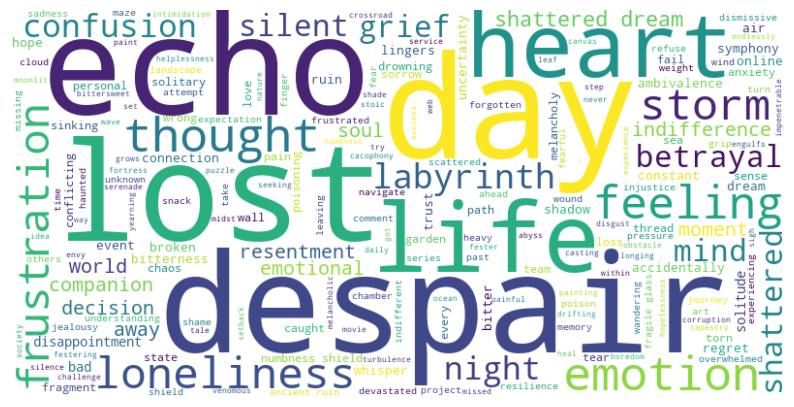

In [196]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Data Preparation

In [197]:
df2 = df1.copy()

In [198]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

Split Data

In [199]:
X = df2['Clean_Text'].values
y = df2['Sentiment'].values

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

In [201]:
vectorizer = TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1, 2),  # Termasuk unigram dan bigram
    stop_words='english'  # Hapus stopwords otomatis
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Passive Aggressive Classifier

In [202]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 0.5, 1.0, 5.0],
    'max_iter': [50, 100, 200],
    'shuffle': [True, False],
}

grid_search = GridSearchCV(
    estimator=PassiveAggressiveClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)
pac_classifier = grid_search.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [203]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)

In [204]:
y_pred = pac_classifier.predict(X_test_tfidf)
accuracy_test = accuracy_score(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

In [205]:
print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_rep_test)

Test Set Results:
Accuracy: 0.8163265306122449
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.85      0.84        40
     neutral       0.40      0.14      0.21        14
    positive       0.83      0.90      0.87        93

    accuracy                           0.82       147
   macro avg       0.69      0.63      0.64       147
weighted avg       0.79      0.82      0.80       147



In [206]:
# Evaluasi model
accuracy = pac_classifier.score(X_test_tfidf, y_test)
print(f"Akurasi model: {accuracy:.2f}")

Akurasi model: 0.82
